<a href="https://colab.research.google.com/github/LucioFassarella/ComQ/blob/main/ComQ_Problema_CorteMaximo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problema do Corte Máximo:

Resolução pela estratégia QAOA

## Instalação de pacotes e métodos

In [60]:
'''
Instalação do Qiskit e pacotes de visualização
'''
!pip install qiskit -U
!pip install qiskit_aer
!pip install qiskit-ibm-runtime

import qiskit
qiskit.__version__

!pip install matplotlib
!pip install pylatexenc

In [61]:
'''
Pacotes e Métodos
'''

# NumPy e SciPy
import numpy as np
import scipy as sp

# Minimizador do SciPy
from scipy.optimize import minimize

# Métodos do Qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.quantum_info import SparsePauliOp, Statevector, Operator
from qiskit.visualization import plot_histogram, array_to_latex, plot_state_city
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
#from qiskit.circuit.library import QAOAAnsatz

# Estimadores do Qiskit
from qiskit_aer.primitives import Estimator # <-- Estimator para simulação clássica
# from qiskit_ibm_runtime import EstimatorV2 as Estimator # <-- Estimator para computação quântica
# from qiskit_ibm_runtime import SamplerV2 as Sampler # <-- Estimator para computação quântica

# Qiskit Runtime
#from qiskit_ibm_runtime import QiskitRuntimeService, Session

import time

In [81]:
'''
Métodos para execução da estratégia QAOA
'''

# Serviço

token_privado = "..." # <- Inserir seu token na IBM
instance_do_projeto = "..." # <- Inserir instance do projeto na IBM

from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(
    channel="ibm_cloud",
    token = token_privado,
    instance = instance_do_projeto
    )

## Backend fake
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
backend = FakeBrisbane() # FakeBrisbane(): 127 qubits. Mais fake backends: 'https://quantum.cloud.ibm.com/docs/en/api/qiskit-ibm-runtime/fake-provider'

# Initialize Estimator
from qiskit_aer.primitives import EstimatorV2
Estimator = EstimatorV2

# Transpilador
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)

## Definição de métodos específicos

In [62]:
def Hamiltoniano_Corte(num_vertices = 'int', pesos = 'list'):
    '''
    Função que contrói o Hamiltoniano de corte para um grafo.

    Entradas:
        n: número de qubits (int)
        w: matriz de pesos (list)

    Saída:
        HC: Hamiltoniano do corte (SparsePauliOp)

    Método requerido:
        from qiskit.quantum_info import SparsePauliOp

    '''

    '''
    ### Verificação da consistência dos dados de entrada
    '''

    if type(num_vertices) != int:
        return print("O primeiro argumento 'num_vertices' deve ser um inteiro positivo")
    if type(pesos) != list:
        return print("O segundo argumento 'pesos' deve ser uma lista quadrada simétrica")
    if num_vertices != len(pesos):
        return print("O comprimento da lista 'pesos' deve ser igual ao primeiro argumento 'num_vertices'")

    '''
    ### Código principal
    '''

    operadores = []

    peso_total = 0
    for j in range(num_vertices):
        for i in range(j):
            peso_total += pesos[i][j]

    operadores.append(("I",[0], peso_total/2))

    for j in range(num_vertices):
        for i in range(j):
            operadores.append(("ZZ",[i,j], -pesos[i][j]/2))

    HC = SparsePauliOp.from_sparse_list(operadores, num_qubits = num_vertices)

    return HC

In [63]:
def Operador_Separador(num_vertices = 'int', pesos = 'list', gama = 'float'):
    '''
    Função que contrói o operador separador da estratégia QAOA para um grafo.

    Entradas:
        n: número de qubits (int)
        w : matriz de pesos (list)
        g: parâmetro real (float)

    Saída:
        qc: circuito quântico com n qubits

    Métodos requeridos:
        qiskit.QuantumCircuit

    '''

    '''
    Verificação da consistência dos dados de entrada
    '''

    if type(num_vertices) != int:
        return print("O primeiro argumento deve ser um inteiro")
    if type(pesos) != list:
        return print("O segundo argumento deve ser uma lista quadrada simétrica")
    if num_vertices != len(pesos):
        return print("O comprimento da lista deve ser igual ao primeiro argumento")

    '''
    Código principal
    '''

    qc = QuantumCircuit(num_vertices, name = "H_P")

    for j in range(num_vertices):
        for i in range(j):
            qc.rzz(gama*pesos[i][j],i,j)

    return qc

In [64]:
def Operador_Misturador(num_vertices = 'int', beta = 'float'):
    '''
    Função que contrói o operador misturador da estratégia QAOA para um grafo.

    Entradas:
        num_vertices: número de qubits (int)
        beta: parâmetro real (float)

    Saída:
        qc: circuito quântico com n qubits

    Métodos requeridos:
        qiskit.QuantumCircuit

    '''

    '''
    Verificação da consistência dos dados de entrada
    '''

    if type(num_vertices) != int:
        return print("O primeiro argumento deve ser um inteiro")

    '''
    Código principal
    '''

    qc = QuantumCircuit(num_vertices, name = "H_M")

    for i in range(num_vertices):
            qc.rx(beta,i)

    return qc

In [65]:
def QAOA_Ansatz(num_vertices = 'int', pesos = 'list', p = 'int', gama_vec = 'list', beta_vec = 'list'):
    '''
    Função que contrói o circuito quântico QAOA para um grafo.

    Entradas:
        num_vertices: número de qubits (int)
        pesos : matriz de pesos (list)
        gama_vec: lista de parâmetros reais (float)
        beta_vec: lista de parâmetros reais (float)

    Saída:
        qc: circuito quântico parametrizado com n qubits.

    Métodos requeridos:
        Hamiltoniano_Corte
        Operador_Separador
        Operador_Misturador

    '''

    '''
    Verificação da consistência dos dados de entrada
    '''
    if type(num_vertices) != int:
        return print("O primeiro argumento 'num_vertices' deve ser um inteiro.")
    if type(pesos) != list:
        return print("O segundo argumento 'pesos' deve ser uma lista quadrada simétrica.")
    if num_vertices != len(pesos):
        return print("O comprimento da lista 'pesos' deve ser igual ao primeiro argumento 'num_vertices'.")
    if type(p) != int:
        return print("O terceiro argumento 'p' deve ser um inteiro.")
    if type(gama_vec) != list:
        return print("O quarto argumento 'gama_vec' deve ser uma lista de floats.")
    if type(beta_vec) != list:
        return print("O quinto argumento 'beta_vec' deve ser uma lista de floats.")
    if len(gama_vec) != p or len(beta_vec) != p:
        return print("Os parâmetros 'gama_vec' e 'beta_vec' devem ter comprimento igual ao terceiro argumento 'p'.")

    '''
    Código principal
    '''

    # Construção do circuito
    qc = QuantumCircuit(num_vertices, name = "QAOA_Ansatz")

    for i in range(num_vertices):
        qc.h(i)

    qubits = range(num_vertices)
    for i in range(p):
        qc.append(Operador_Separador(num_vertices, pesos, gama_vec[i]), qubits)
        qc.append(Operador_Misturador(num_vertices, beta_vec[i]), qubits)

    return qc

In [66]:
def CorteQ(parametros = 'list', num_vertices = 'int', pesos = 'list', p = 'int', estimator = 'qiskit_aer.primitives'):
    '''
    Função que retorna o corte de uma partição do grafo

    Entradas:
        estimator: estimador quântico (Estimator)
        num_vertices: número de qubits (int)
        pesos: matriz de pesos (list)
        p: profundidade do ansatz QAOA (int)
        parametros: 'gama_vec + beta_vec' = lista de parâmetros combinando parâmetros de separação e  parâmetros de mistura

    Saída:
        cost = float: custo

    Métodos requeridos:
        QAOA_Ansatz
        Estimator
        pass_manager: Qiskit PassManager

    Observações:
        Para executar esta função, é necessário previamente definir o "estimator"
        e inicializar o transpilador pelo comando
        "pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)"
    '''
    # Construção do circuito QAOA
    gama_vec = list(parametros[:p])
    beta_vec = list(parametros[p:])
    QAOA = QAOA_Ansatz(num_vertices, pesos, p, gama_vec, beta_vec)

    # Cálculo do corte
    QAOA_transpilado = pass_manager.run(QAOA)
    HC = Hamiltoniano_Corte(num_vertices, pesos)
    HC_transpilado = HC.apply_layout(QAOA_transpilado.layout)
    job = estimator.run([(QAOA_transpilado, HC_transpilado)])
    corte = job.result()[0].data.evs

    return corte

In [67]:
'''
Funções auxiliares para pós-processamento

(Elas definem representações de inteiros em base arbitrária e vice-versa)
'''

# Função que calcula o corte máximo de um grafo
def MaxCut(num_vertices, pesos):
    '''
    Função que calcula o corte máximo de uma partição de um grafo

    Entradas:
        num_vertices (int): número de vértices do grafo
        pesos (list): matriz de pesos do grafo

    Saída:
        corte_max (float): corte máximo do grafo
        particao_max (lista): lista com a partição de corte máxima:  [Amax,Bmax]
    '''
    corte_max = 0
    for p in range(2**num_vertices):
        A = []
        B = []
        for k in range(num_vertices):
            if (p // 2**k) % 2 == 1:
                A.append(k)
            else:
                B.append(k)
        corte = Corte(pesos,A)
        if corte > corte_max:
            corte_max = corte
            particao_max = [A,B]
    return corte_max, particao_max

# Função que calcula o corte de uma partição de um grafo
def Corte(pesos,A):
    '''
    Função que calcula o corte de uma partição de um grafo

    Entradas:
        pesos: matriz de pesos (list)
        A: lista de vértices da partição

    Saída:
        corte: corte da partição (float)
    '''

    num_vertices = len(pesos)
    corte = 0
    for i in range(num_vertices):
        for j in range(i):
            if (i in A and j not in A) or (j in A and i not in A):
                corte += pesos[i][j]

    return corte

# Função que retorna o estado da base computacional mais proeminente de um estado gerado por um circuito quântico
def estado_base_max(qc, num_qubits):
    '''
    Determina o estado da base computacional que tem maior probabilidade no estado
     gerado por um circuito quântico 'qc' num registro quântico com 'num_qubits' qubits.

    Entradas:
        qc (QuantumCircuit): circuito quântico
        num_qubits (int): número de qubits do circuito

    Saída:
        string: o estado da base com maior probabilidade, na forma de string binária

    Métodos:
        qiskit.QuantumCircuit
        qiskit.quantum_info.Statevector
        numpy as np
    '''

    estado = Statevector.from_instruction(qc)
    probabilidades = estado.probabilities()
    estado_base_maximo = np.argmax(probabilidades)
    return format(estado_base_maximo, f'0{num_qubits}b')

# Função que retorna a lista de comprimento 'l' com os dígitos na base 'b' de um inteiro 'x' dado na base 10
def numero_para_digitos(numero = 'int', base = 'int', num_digitos = 'int'):
    '''
    Função que retorna a lista de dígitos do inteiro 'numero'  na base 'base'
    com comprimento 'num_digitos' (no mínimo) e na ordem anti-lexicográfica

    Entradas:
        base : inteiro positivo : base
        numero : inteiro a ser apresentado na base 'b'
        num_digitos: inteiro positivo : comprimento da representação

    Saída:
        list : lista de inteiros positivos
    '''
    if numero < 0:
        sign = -1
    else:
        sign = 1

    numero *= sign

    ordem = 0
    while numero >= base**ordem:
        ordem += 1

    ordem = max(ordem, num_digitos)

    digitos = [0 for k in range(ordem)]

    x = numero
    for k in range(ordem):
        expoente = ordem - k - 1
        digitos[k] = x // base**expoente
        x = x % base**expoente

    return np.array(digitos)

# Função que retorna o número escrito na base 10 para dada lista 'lista' com seus dígitos na base 'b'
def digitos_para_numero(digitos = 'list', base = 'int'):
    '''
    Função que apresenta na base '10' um inteiro dado pela lista 'lista'
    de seus dígitos na base 'b' na ordem anti-lexicográfica

    Entradas:
        base (int): base
        digitos (list): lista de digitos do número na base b

    Saída:
        int : número na base 10 representado por 'digitos' dado na base 'base'
    '''
    ordem = len(digitos)
    n = 0
    for k in range(0,ordem):
        n = n + digitos[k]*(5**(ordem - k - 1))
    return n

## Exemplos

### Exemplo 1: Grafo com 5 vértices

Dimensão do grafo: 5
Matriz de pesos:


[[0, 1, 0, 0, 1],
 [1, 0, 1, 0, 1],
 [0, 1, 0, 1, 0],
 [0, 0, 1, 0, 1],
 [1, 1, 0, 1, 0]]

Grafo:


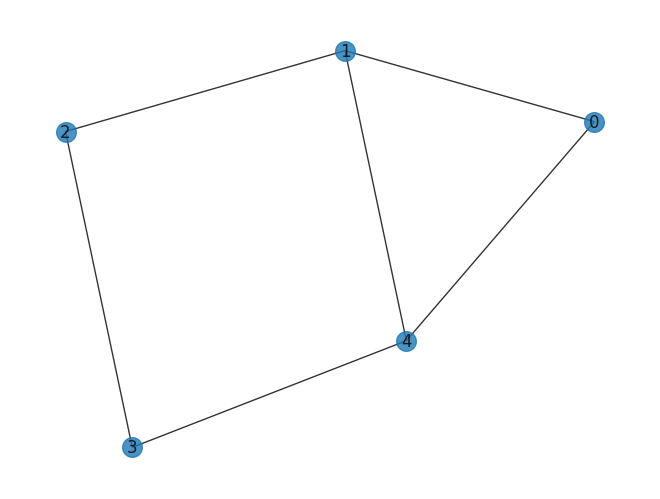

In [18]:
'''
Grafo
'''

num_vertices = 5
print(f"Dimensão do grafo: {num_vertices}")

pesos = [
   [0,1,0,0,1],
   [1,0,1,0,1],
   [0,1,0,1,0],
   [0,0,1,0,1],
    [1,1,0,1,0]
]
print("Matriz de pesos:")
display(pesos)

# Impressão do grafo
import networkx as nx

G = nx.Graph()
vertices = range(num_vertices)
G.add_nodes_from(vertices)

arestas = []
for i in range(num_vertices):
    for j in range(num_vertices):
        if pesos[i][j] != 0:
            arestas.append((i,j))
G.add_edges_from(arestas)

print("Grafo:")
nx.draw(G, with_labels=True, alpha=0.8, node_size=200)

In [21]:
'''
Resolução clássica
'''

corte_maximo = MaxCut(num_vertices, pesos)

print(f"Corte máximo: {corte_maximo[0]}")
print(f"Partição de corte máxima: {corte_maximo[1]}")

Corte máximo: 5
Partição de corte máxima: [[1, 3], [0, 2, 4]]


In [ ]:
'''
Estratégia QAOA
'''
import time
inicio = time.time()

# Profundidade
p = 4
print(f"Profundidade: {p} (tipo: {type(p)}")

# Parâmetros iniciais
parametros_iniciais = [2*np.pi*np.random.random() for k in range(2*p)]
print(f"Parâmetros iniciais: {parametros_iniciais}")

# Negativo de CorteQ
def neg_CorteQ(parametros, num_vertices, pesos, p, estimator):
    valor = CorteQ(parametros, num_vertices, pesos, p, estimator)
    return -valor

# Maximização de CorteQ (pela minimização de -CorteQ = neg_CorteQ)
parametros = parametros_iniciais
estimator = Estimator()
corte = minimize(neg_CorteQ, parametros, args = (num_vertices, pesos, p, estimator), tol = 1/2**12, method="COBYLA")
parametros_max = corte.x
corte_max = - corte.fun #Troca de sinal
print(f"Parâmetros finais: {parametros_max}")
print(f"Corte: {corte_max}")

fim = time.time()
print(f"Tempo de execução: {(fim - inicio)/60} minutos")

Profundidade: 4 (tipo: <class 'int'>
Parâmetros iniciais: [0.147766282659124, 5.2172115846249945, 2.7733446925422007, 1.8491876342727505, 5.3482239109887555, 1.1082538199232663, 3.096410475795309, 4.482882160064489]
Parâmetros finais: [0.14716748 5.75884762 3.01860507 2.2353252  5.22514059 0.91000866
 3.08670041 3.74187329]
Corte: 4.647103320997832
Tempo de execução: 2.0425822933514914 minutos


In [ ]:
'''
Pós-processamento
'''

gama_vec = list(parametros_max[:p])
beta_vec = list(parametros_max[p:])

circ = QAOA_Ansatz(num_vertices, pesos, p, gama_vec, beta_vec)

# Estado de corte máximo
estado_maxcut = estado_base_max(circ,n)
print(f"Estado-base de corte máximo: {estado_maxcut}")

# Partição de corte máximo
A = []; B = []
for k in range(num_vertices):
    if estado_maxcut[k] == '1':
        A.append(k)
    else:
        B.append(k)
print(f"Corte Máximo: {Corte(pesos, A)}. Partição de corte máximo: {(A,B)}")

Estado-base de corte máximo: 01011
Corte Máximo: 4. Partição de corte máximo: ([1, 3, 4], [0, 2])


### Exemplo 2: Grafo com subgrafos de 5 vértices

Dimensão do grafo: 10
Matriz de pesos:


[[0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
 [1, 0, 1, 0, 1, 0, 0, 0, 0, 0],
 [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
 [1, 1, 0, 1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
 [0, 0, 0, 0, 0, 1, 0, 1, 0, 1],
 [0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
 [0, 0, 0, 0, 0, 1, 1, 0, 1, 0]]

Grafo:


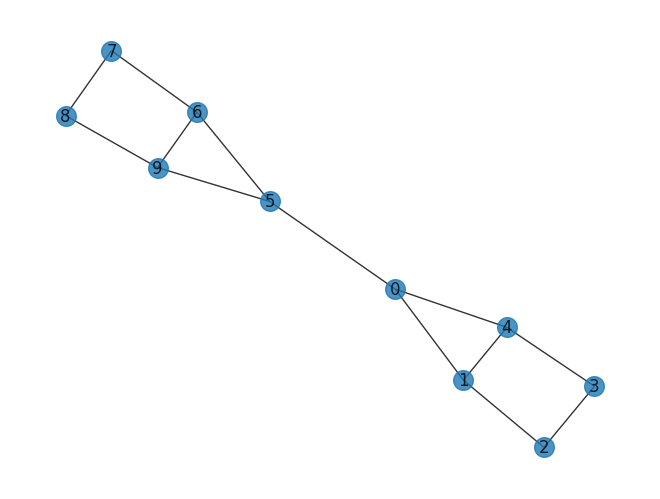

In [22]:
'''
Grafo
'''

num_vertices = 10
print(f"Dimensão do grafo: {num_vertices}")

pesos = [
   [0,1,0,0,1,1,0,0,0,0],
   [1,0,1,0,1,0,0,0,0,0],
   [0,1,0,1,0,0,0,0,0,0],
   [0,0,1,0,1,0,0,0,0,0],
   [1,1,0,1,0,0,0,0,0,0],
   [1,0,0,0,0,0,1,0,0,1],
   [0,0,0,0,0,1,0,1,0,1],
   [0,0,0,0,0,0,1,0,1,0],
   [0,0,0,0,0,0,0,1,0,1],
    [0,0,0,0,0,1,1,0,1,0]
]
print("Matriz de pesos:")
display(pesos)

# Impressão do grafo
import networkx as nx

G = nx.Graph()
vertices = range(num_vertices)
G.add_nodes_from(vertices)

arestas = []
for i in range(num_vertices):
    for j in range(num_vertices):
        if pesos[i][j] != 0:
            arestas.append((i,j))
G.add_edges_from(arestas)

print("Grafo:")
nx.draw(G, with_labels=True, alpha=0.8, node_size=200)

In [23]:
'''
Resolução clássica
'''

corte_maximo = MaxCut(num_vertices, pesos)

print(f"Corte máximo: {corte_maximo[0]}")
print(f"Partição de corte máxima: {corte_maximo[1]}")

Corte máximo: 11
Partição de corte máxima: [[0, 1, 3, 6, 8], [2, 4, 5, 7, 9]]


In [31]:
'''
Estratégia QAOA
'''
import time
inicio = time.time()

# Profundidade
p = 4
print(f"Profundidade: {p} (tipo: {type(p)}")

# Parâmetros iniciais
parametros_iniciais = [2*np.pi*np.random.random() for k in range(2*p)]
print(f"Parâmetros iniciais: {parametros_iniciais}")

# Negativo de CorteQ
def neg_CorteQ(parametros, num_vertices, pesos, p, estimator):
    valor = CorteQ(parametros, num_vertices, pesos, p, estimator)
    return -valor

# Maximização de CorteQ (pela minimização de -CorteQ = neg_CorteQ)
parametros = parametros_iniciais
estimator = Estimator()
corte = minimize(neg_CorteQ, parametros, args = (num_vertices, pesos, p, estimator), tol = 1/2**15, method="COBYLA")
parametros_max = corte.x
corte_max = - corte.fun #Troca de sinal
print(f"Parâmetros finais: {parametros_max}")
print(f"Corte: {corte_max}")

fim = time.time()
print(f"Tempo de execução: {(fim - inicio)/60} minutos")

Profundidade: 4 (tipo: <class 'int'>
Parâmetros iniciais: [3.1046083477930395, 2.087332249758763, 4.252231271880097, 0.2973792736646088, 3.6784642391514977, 0.8197338337087354, 0.9305963455903764, 5.539711407403096]
Parâmetros finais: [3.20929464 2.69948654 5.27036984 0.20182038 4.4470988  0.9413942
 1.96931798 4.95579965]
Corte: 10.307021638251289
Tempo de execução: 5.7879005670547485 minutos


In [33]:
'''
Pós-processamento
'''

gama_vec = list(parametros_max[:p])
beta_vec = list(parametros_max[p:])

circ = QAOA_Ansatz(num_vertices, pesos, p, gama_vec, beta_vec)

# Estado de corte máximo
estado_maxcut = estado_base_max(circ,num_vertices)
print(f"Estado-base de corte máximo: {estado_maxcut}")

# Partição de corte máximo
A = []; B = []
for k in range(num_vertices):
    if estado_maxcut[k] == '1':
        A.append(k)
    else:
        B.append(k)
print(f"Corte Máximo: {Corte(pesos, A)}. Partição de corte máximo: {(A,B)}")

Estado-base de corte máximo: 0101001011
Corte Máximo: 9. Partição de corte máximo: ([1, 3, 6, 8, 9], [0, 2, 4, 5, 7])


### Exemplo 3: Grafo com 12 vértices

Dimensão do grafo: 12
Matriz de pesos:


[[0, 5, -2, 3, 1, -4, 2, -1, 6, 4, -3, 0],
 [5, 0, 4, -1, 2, 3, -2, 1, -5, 0, 2, -1],
 [-2, 4, 0, 2, -3, 1, 5, 0, 3, -2, 1, 4],
 [3, -1, 2, 0, 4, 1, -2, 5, 0, 2, 3, -1],
 [1, 2, -3, 4, 0, -2, 1, 3, -1, 5, 0, 2],
 [-4, 3, 1, 1, -2, 0, 4, -3, 2, 1, 5, -2],
 [2, -2, 5, -2, 1, 4, 0, 3, 2, 1, -4, 3],
 [-1, 1, 0, 5, 3, -3, 3, 0, 1, 2, 4, -2],
 [6, -5, 3, 0, -1, 2, 2, 1, 0, 4, -3, 1],
 [4, 0, -2, 2, 5, 1, 1, 2, 4, 0, 3, -2],
 [-3, 2, 1, 3, 0, 5, -4, 4, -3, 3, 0, 1],
 [0, -1, 4, -1, 2, -2, 3, -2, 1, -2, 1, 0]]

Grafo:


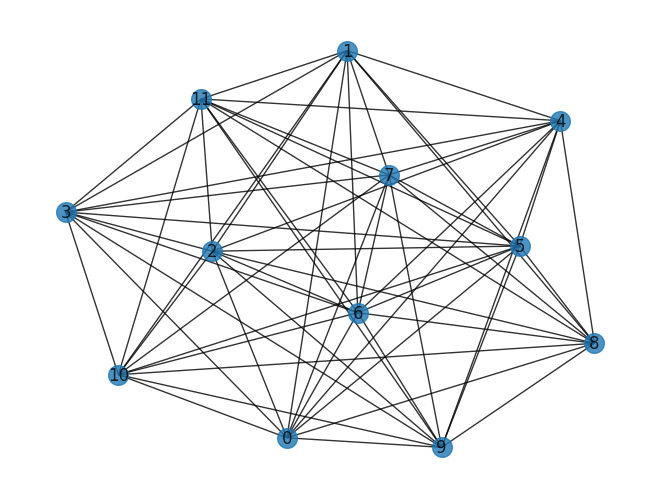

In [68]:
'''
Grafo
'''

num_vertices = 12
print(f"Dimensão do grafo: {num_vertices}")


pesos = [
    [ 0,  5, -2,  3,  1, -4,  2, -1,  6,  4, -3,  0],
    [ 5,  0,  4, -1,  2,  3, -2,  1, -5,  0,  2, -1],
    [-2,  4,  0,  2, -3,  1,  5,  0,  3, -2,  1,  4],
    [ 3, -1,  2,  0,  4,  1, -2,  5,  0,  2,  3, -1],
    [ 1,  2, -3,  4,  0, -2,  1,  3, -1,  5,  0,  2],
    [-4,  3,  1,  1, -2,  0,  4, -3,  2,  1,  5, -2],
    [ 2, -2,  5, -2,  1,  4,  0,  3,  2,  1, -4,  3],
    [-1,  1,  0,  5,  3, -3,  3,  0,  1,  2,  4, -2],
    [ 6, -5,  3,  0, -1,  2,  2,  1,  0,  4, -3,  1],
    [ 4,  0, -2,  2,  5,  1,  1,  2,  4,  0,  3, -2],
    [-3,  2,  1,  3,  0,  5, -4,  4, -3,  3,  0,  1],
    [ 0, -1,  4, -1,  2, -2,  3, -2,  1, -2,  1,  0]
]

print("Matriz de pesos:")
display(pesos)

# Impressão do grafo
import networkx as nx

G = nx.Graph()
vertices = range(num_vertices)
G.add_nodes_from(vertices)

arestas = []
for i in range(num_vertices):
    for j in range(num_vertices):
        if pesos[i][j] != 0:
            arestas.append((i,j))
G.add_edges_from(arestas)

print("Grafo:")
nx.draw(G, with_labels=True, alpha=0.8, node_size=200)

In [69]:
'''
Resolução clássica
'''

corte_maximo = MaxCut(num_vertices, pesos)

print(f"Corte máximo: {corte_maximo[0]}")
print(f"Partição de corte máxima: {corte_maximo[1]}")

Corte máximo: 76
Partição de corte máxima: [[1, 3, 6, 8, 10], [0, 2, 4, 5, 7, 9, 11]]


In [71]:
'''
Estratégia QAOA
'''
import time
inicio = time.time()

# Profundidade
p = 7
print(f"Profundidade: {p} (tipo: {type(p)}")

# Negativo de CorteQ
def neg_CorteQ(parametros, num_vertices, pesos, p, estimator):
    valor = CorteQ(parametros, num_vertices, pesos, p, estimator)
    return -valor

# Estimador
estimator = Estimator()

# Parâmetros iniciais
parametros_iniciais = [2*np.pi*np.random.random() for k in range(2*p)]
print(f"Parâmetros iniciais: {parametros_iniciais}")

# Maximização de CorteQ (pela minimização de -CorteQ = neg_CorteQ)
parametros = parametros_iniciais
corte_0 = CorteQ(parametros, num_vertices, pesos, p, estimator)
print(f"Corte inicial (iteração 0): {corte_0}")

# Iterações do minimize
num_repeticoes = 3
for k in range(num_repeticoes):
    corte = minimize(neg_CorteQ, parametros, args = (num_vertices, pesos, p, estimator), tol = 1/2**15, method="COBYQA")
    parametros = corte.x
    print(f"Parâmetros na iteração {k+1}: {corte.x}")
    print(f"Corte na iteração {k+1}: {-corte.fun}")

parametros_max = corte.x
corte_max = - corte.fun #Troca de sinal
print(f"Parâmetros finais: {parametros_max}")
print(f"Corte: {corte_max}")
#print(f"Número de iterações: {corte.int}")
print(f"Processo bem sucedido?: {corte.success}")
print(f"Mensagem do Cobyla: {corte.message}")

fim = time.time()
print(f"Tempo de execução: {(fim - inicio)/60} minutos")

Profundidade: 7 (tipo: <class 'int'>
Parâmetros iniciais: [0.36892169757448046, 1.0452759277613108, 3.200951253020803, 1.028983947521665, 4.697901772146586, 0.46668679787930667, 3.4022905892042337, 0.21380788192630207, 3.50797621088474, 0.921790295101615, 5.768072809091453, 4.237271513972136, 3.3342037973071315, 4.650425586396766]
Corte inicial (iteração 0): 33.40734707983904
Parâmetros na iteração 1: [0.29915449 1.30110974 3.11296067 1.04979752 4.71879868 0.35982972
 3.42946033 0.21271578 3.43493264 1.13425761 4.76762915 4.11207257
 3.45487082 4.7149506 ]
Corte na iteração 1: 34.6081595454241
Parâmetros na iteração 2: [0.29915631 1.30111026 3.11295685 1.04980129 4.71880047 0.35982879
 3.42946043 0.2127042  3.43493149 1.13425238 4.76762961 4.11206518
 3.45485955 4.71496502]
Corte na iteração 2: 34.60815954633816
Parâmetros na iteração 3: [0.29916278 1.30110662 3.11295162 1.04979643 4.71880027 0.35982832
 3.42946096 0.21271077 3.43493341 1.13424824 4.76761063 4.1120479
 3.45485414 4.714

In [72]:
'''
Pós-processamento
'''

gama_vec = list(parametros_max[:p])
beta_vec = list(parametros_max[p:])

circ = QAOA_Ansatz(num_vertices, pesos, p, gama_vec, beta_vec)

# Estado de corte máximo
estado_maxcut = estado_base_max(circ,num_vertices)
print(f"Estado-base de corte máximo: {estado_maxcut}")

# Partição de corte máximo
A = []; B = []
for k in range(num_vertices):
    if estado_maxcut[k] == '1':
        A.append(k)
    else:
        B.append(k)
print(f"Corte Máximo: {Corte(pesos, A)}. Partição de corte máximo: {(A,B)}")

Estado-base de corte máximo: 000001011001
Corte Máximo: 38. Partição de corte máximo: ([5, 7, 8, 11], [0, 1, 2, 3, 4, 6, 9, 10])


### Exemplo XXX: Grafo com 14 vértices e pesos variáveis

Dimensão do grafo: 14
Matriz de pesos:


[[0.0, 0.36, 0.47, 0.14, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.36, 0.0, 0.0, 0.0, 0.16, 0.0, 0.69, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.47, 0.0, 0.0, 0.37, 0.0, 0.56, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.14, 0.0, 0.37, 0.0, 0.0, 0.0, 0.76, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.82, 0.7, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.56, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9, 0.16, 0.0, 0.0, 0.0],
 [0.0, 0.69, 0.0, 0.76, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.89, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.82, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.76, 0.19, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.7, 0.0, 0.0, 0.0, 0.0, 0.66, 0.0, 0.0, 0.0, 0.52],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.9, 0.0, 0.0, 0.66, 0.0, 0.0, 0.43, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.76, 0.15],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.89, 0.76, 0.0, 0.43, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19, 0.0, 0.0, 0.76, 0.0, 0.0, 0.38],
 [0.0, 0.0, 0.0,

Grafo:


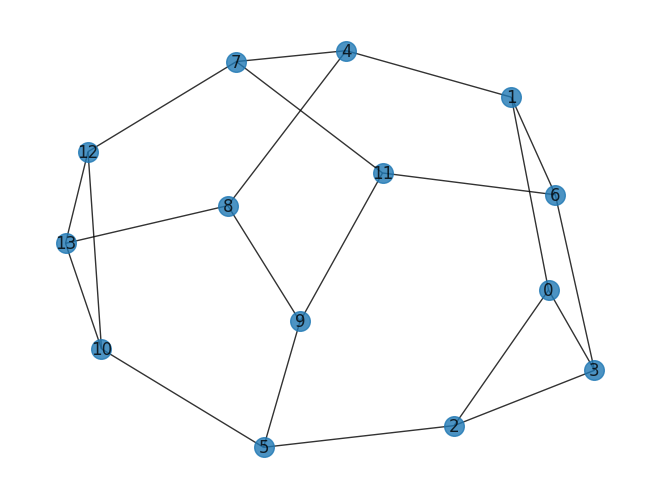

In [75]:
'''
Grafo
'''

num_vertices = 14
print(f"Dimensão do grafo: {num_vertices}")

pesos = [
   [0.00,0.36,0.47,0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00],
   [0.36,0.00,0.00,0.00,0.16,0.00,0.69,0.00,0.00,0.00,0.00,0.00,0.00,0.00],
   [0.47,0.00,0.00,0.37,0.00,0.56,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00],
   [0.14,0.00,0.37,0.00,0.00,0.00,0.76,0.00,0.00,0.00,0.00,0.00,0.00,0.00],
   [0.00,0.16,0.00,0.00,0.00,0.00,0.00,0.82,0.70,0.00,0.00,0.00,0.00,0.00],
   [0.00,0.00,0.56,0.00,0.00,0.00,0.00,0.00,0.00,0.90,0.16,0.00,0.00,0.00],
   [0.00,0.69,0.00,0.76,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.89,0.00,0.00],
   [0.00,0.00,0.00,0.00,0.82,0.00,0.00,0.00,0.00,0.00,0.00,0.76,0.19,0.00],
   [0.00,0.00,0.00,0.00,0.70,0.00,0.00,0.00,0.00,0.66,0.00,0.00,0.00,0.52],
   [0.00,0.00,0.00,0.00,0.00,0.90,0.00,0.00,0.66,0.00,0.00,0.43,0.00,0.00],
   [0.00,0.00,0.00,0.00,0.00,0.16,0.00,0.00,0.00,0.00,0.00,0.00,0.76,0.15],
   [0.00,0.00,0.00,0.00,0.00,0.00,0.89,0.76,0.00,0.43,0.00,0.00,0.00,0.00],
   [0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.19,0.00,0.00,0.76,0.00,0.00,0.38],
   [0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.52,0.00,0.15,0.00,0.38,0.00]
]
print("Matriz de pesos:")
display(pesos)

# Impressão do grafo
import networkx as nx

G = nx.Graph()
vertices = range(num_vertices)
G.add_nodes_from(vertices)

arestas = []
for i in range(num_vertices):
    for j in range(num_vertices):
        if pesos[i][j] != 0:
            arestas.append((i,j))
G.add_edges_from(arestas)

print("Grafo:")
nx.draw(G, with_labels=True, alpha=0.8, node_size=200)

In [76]:
'''
Resolução clássica
'''

corte_maximo = MaxCut(num_vertices, pesos)

print(f"Corte máximo: {corte_maximo[0]}")
print(f"Partição de corte máxima: {corte_maximo[1]}")

Corte máximo: 9.53
Partição de corte máxima: [[0, 5, 6, 7, 8, 12], [1, 2, 3, 4, 9, 10, 11, 13]]


In [78]:
'''
Estratégia QAOA
'''
import time
inicio = time.time()

# Profundidade
p = 7
print(f"Profundidade: {p} (tipo: {type(p)}")

# Negativo de CorteQ
def neg_CorteQ(parametros, num_vertices, pesos, p, estimator):
    valor = CorteQ(parametros, num_vertices, pesos, p, estimator)
    return -valor

# Estimador
estimator = Estimator()

# Parâmetros iniciais
parametros_iniciais = [2*np.pi*np.random.random() for k in range(2*p)]
print(f"Parâmetros iniciais: {parametros_iniciais}")

# Maximização de CorteQ (pela minimização de -CorteQ = neg_CorteQ)
parametros = parametros_iniciais
corte_0 = CorteQ(parametros, num_vertices, pesos, p, estimator)
print(f"Corte inicial (iteração 0): {corte_0}")

# Iterações do minimize
num_repeticoes = 3
for k in range(num_repeticoes):
    corte = minimize(neg_CorteQ, parametros, args = (num_vertices, pesos, p, estimator), tol = 1/2**15, method="COBYQA")
    parametros = corte.x
    print(f"Parâmetros na iteração {k+1}: {corte.x}")
    print(f"Corte na iteração {k+1}: {-corte.fun}")

parametros_max = corte.x
corte_max = - corte.fun #Troca de sinal
print(f"Parâmetros finais: {parametros_max}")
print(f"Corte: {corte_max}")
#print(f"Número de iterações: {corte.int}")
print(f"Processo bem sucedido?: {corte.success}")
print(f"Mensagem do Cobyla: {corte.message}")

fim = time.time()
print(f"Tempo de execução: {(fim - inicio)/60} minutos")

Profundidade: 7 (tipo: <class 'int'>
Parâmetros iniciais: [3.594217159034606, 3.16042487973716, 1.606493647446588, 4.334589008645868, 3.8191149626105427, 4.8779383563673715, 0.5155425516672397, 6.062810151324669, 3.6323918277320066, 0.46146606241015203, 6.225705202850779, 5.2837143533507085, 0.14366704096241953, 5.444546440411014]
Corte inicial (iteração 0): 5.422050497434964
Parâmetros na iteração 1: [ 0.82138446  1.55536951  3.96086226  2.40010475  6.33698494  5.96495454
 -1.93683772  5.25080913  2.59576517  0.03663744  6.34171039  6.2626016
  0.13974223  6.3638724 ]
Corte na iteração 1: 8.353164208968789
Parâmetros na iteração 2: [ 0.8213856   1.55536836  3.96085384  2.40011353  6.33698732  5.96494463
 -1.93684192  5.25080766  2.59576618  0.03663799  6.3417106   6.26260162
  0.13974014  6.36387111]
Corte na iteração 2: 8.35316420900539
Parâmetros na iteração 3: [ 0.8213856   1.55536836  3.96085384  2.40011353  6.33698732  5.96494463
 -1.93684192  5.25080766  2.59576618  0.03663799  

In [80]:
'''
Pós-processamento
'''

gama_vec = list(parametros_max[:p])
beta_vec = list(parametros_max[p:])

circ = QAOA_Ansatz(num_vertices, pesos, p, gama_vec, beta_vec)

# Estado de corte máximo
estado_maxcut = estado_base_max(circ,num_vertices)
print(f"Estado-base de corte máximo: {estado_maxcut}")

# Partição de corte máximo
A = []; B = []
for k in range(num_vertices):
    if estado_maxcut[k] == '1':
        A.append(k)
    else:
        B.append(k)
print(f"Corte Máximo: {Corte(pesos, A)}. Partição de corte máximo: {(A,B)}")

Estado-base de corte máximo: 01000111100001
Corte Máximo: 7.450000000000001. Partição de corte máximo: ([1, 5, 6, 7, 8, 13], [0, 2, 3, 4, 9, 10, 11, 12])
